# CS 4375 Project - Training an RL Agent to play the offline Google Dino Game
> Mikkael Dumancas (mxd220018)

## Briefing

I chose to do option 3 for the project and centered around Reinforcement Learning. At a high level, reinforcement learning is a machine learning technique that uses 4 key concepts:
- Action
- Reward
- Environment
- Agent

The RL model, or agent, interacts with an environment with the sole goal of taking actions to maximize a reward value. At runtime, this boils down to a simple loop of:

1. The agent makes an observation about the environment
2. The agent selects an action
3. The environment uses this action to determine the reward and the next observation for the agent
4. The cycle (1-3) continues until the environment ends/terminates

## Downloading Dependencies

This project is coded in Python 3 using the PyTorch framework. The relevant dependencies used for this project are as follows:

- Stable-baselines3: A PyTorch-based library that is used to implement Reinforcement Learning algorithms (for this project, I use DQN)
- Gymnasium: A Python library/toolkit developed by OpenAI to handle testing RL algorithms. I utilize its standard API and environment building to handle agent-environment interactions.
- MSS: A simple Python module that takes a screenshot of a screen. This is just a lightweight, faster way to grab observations compared to OpenCV.
- Pydirectinput: This python library enables direct interaction with the mouse and keyboard, so it makes actions that the RL agent takes very fast.
- Numpy: A python library that makes array/matrix handling a lot easier. This helps with processing images (like screenshots from MSS).
- OpenCV: This is a computer vision library with useful tools to preprocess the screen captures from the environment

In [ ]:
!pip3 install torch torchvision torchaudio

In [ ]:
!pip3 install stable-baselines3[extra] protobuf==3.20.*

In [ ]:
!pip3 install mss

In [ ]:
!pip3 install pydirectinput

In [ ]:
!pip3 install keyboard

In [1]:
from mss import mss
import pydirectinput
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
import keyboard
from gymnasium import Env
from gymnasium.spaces import Box, Discrete

## Environment

Building the environment using Gymnasium is just like setting up a class. The primary methods that are needed to build a Gymnasium environment are the constructor(__init__) method and the step method. The constructor sets up the environment and observation shapes. The step method is essentially one iteration of the loop previously mentioned. A step, when called, will simulate an observation, an agent action, and the environment response.

In [57]:
class Game(Env):
    # set up environment and observation shapes
    def __init__(self):
        # subclass the model
        super().__init__()
        # set up spaces (gymnasium containers to represent an observation and actions)
        self.observation_space = Box(low=0, high=255, shape=(1,83,150), dtype=np.uint8)
        self.action_space = Discrete(3) # define 3 unique actions agent can take
        # set up parameters for game extracting an observation of the game using mss
        self.cap = mss()
        # defining observation of environment window size (preprocessing)
        self.game_location = {'top':150, 'left':80, 'width':600, 'height':200}
        self.done_location = {'top':185, 'left':330, 'width':300, 'height':70}

    # simulate agent observation, action, and environment response
    def step(self, action):
        # agent has 3 actions - 0 = jump (space), 1 = crouch (down key), 2 = nothing
        action_map = {
            0: 'space',
            1: 'down',
            2: 'no_op'
        }
        # use pydirectinput to press key related to desired action
        if action != 2:
            pydirectinput.press(action_map[action])
        
        # Gymnasium defines 4 outputs for step: next_observation, reward, terminate, info

        # check if game is done/environment is terminated
        done, done_cap = self.get_done()
        # check if game is done IF TIME CONSTRAINT IS ADDED TO EPISODE
        truncated = False
        # get the next observation of the environment to return to the agent
        next_observation = self.get_observation()
        # give the agent a reward of 1 for each frame it is alive
        reward = 1 
        info = {} # can leave info empty, not entirely necessary for this project
        return next_observation, reward, done, truncated, info
    
    # visualize the game (not really used since I implement game capture via mss)
    def render(self):
        cv2.imshow('Game,', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()

    # ends an observation
    def close(self):
        cv2.destroyAllWindows()

    # reset the game environment (can follow environment termination)
    def reset(self, *, seed=None, option=None):
        # set seed for reproducibility of the reset
        if seed is not None:
            np.random.seed(seed)
        
        #set buffer between transitions
        # time.sleep(1.5)
        #move mouse to top left of screen and click to restart game
        pydirectinput.click(x=300, y=300)
        pydirectinput.press('space')
        
        # Gymnasium requires an observation and info to be returned
        info = {}
        return self.get_observation(), info

    # extra methods not required to build Gymnasium environment

    # grab observation of the game environment
    def get_observation(self):
        # grab raw screen capture of the game_location using mss and turning it into an array
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
        # preprocessing
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (150,83))
        channel = np.reshape(resized, (1,83,150))
        return raw
    # extract game over text with OCR via pytesseract
    def get_done(self):
        done = False
        # grab raw screen capture of the done_location using mss
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        # coordinates for checking if a certain pixel of game over exists
        check_x, check_y = 38, 200
        pixel_color = done_cap[check_x, check_y]
        # specific rgb value that is expected to appear when game is over
        game_over_rgb = np.array([172,172,172])
        tolerance = 10
        if np.all(np.abs(pixel_color - game_over_rgb) <= tolerance):
            done = True
        
        return done, done_cap
    


## Test Environment

Now that the environment has been built, it is fairly simple to test out the environment. Create a new instance of the game called env, and from there run the methods.

In [58]:
env = Game()

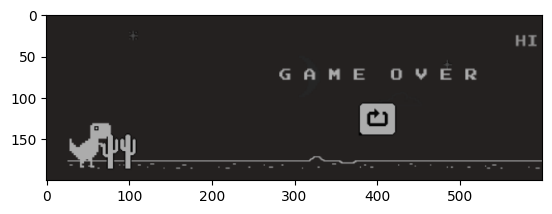

In [60]:
obs = env.get_observation()
plt.imshow(obs)

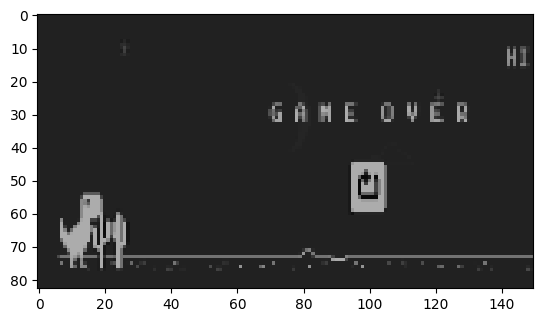

In [56]:
plt.imshow(cv2.cvtColor(obs[0],  cv2.COLOR_BGR2RGB))

In [ ]:
done, done_cap = env.get_done()
plt.imshow(done_cap)
print(done)
print(done_cap[38,93])

In [ ]:
env.render()

In [ ]:
env.close()

In [ ]:
env.reset()

After testing all the methods, here is a sample run of a training step for the environment

In [ ]:
for episode in range(3):
    obs = env.reset()
    done = False
    total_reward = 0

    while not done:
        obs, reward, done, truncated, info = env.step(env.action_space.sample())
        total_reward += reward
    
    print(f'Total Reward for episode {episode} is {total_reward}')

## Training the Model

The RL algorithm I am going to be using is a deep Q-network, also known as DQN. It is a similar network topology to a standard neural network, except it is based on Q-learning. Q-learning is essentially the same as what is described in the briefing. It is centered around an agent moving through different states through actions and receiving rewards until the episode terminates. Mapping this to the gymnasiunm lingo, we can see that:

- Q-values are rewards
- States are different observations of the environment
- Agent actions and rewards are functionally the same
- An episode is one iteration (in gymnasium, it is one execution of step)

Before training the DQN, I am going to be setting up callbacks. Callbacks are a technique used in ML model training (in this case, stable-baselines3 has functions to set up callbacks) to help handle training more easily without directly changing the core algorithm. I am going to be using callbacks specifically for:

- Performance monitoring
- Logging

### Setting up Callbacks

In [6]:
import os
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common import env_checker

In [9]:
# check the environment to see if it complies with Gymnasium's requirements
env_checker.check_env(env)

In [7]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True

In [8]:
CHECKPOINT_DIR = './runs/'
LOG_DIR = './logs/'

In [9]:
# set up callback to occur every 1000 steps and save it to the designated directory
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

### Build/Train DQN

After researching a little bit, DQN is essentially a neural network that approximates a Q-value function (this is the function used to calculate the reward for the agent based on its action within a state). It amplifies the computing power of Q-learning, which is limited to a table.
After understanding DQN on a conceptual level, I explored how it is actually implemented in PyTorch. Since I am working with an RL model, I need to pass a policy to the DQN. 

In [2]:
# Get DQN algorithm from stable_baselines3 library
from stable_baselines3 import DQN

In [12]:
class Game(Env):
    # set up environment and observation shapes
    def __init__(self):
        # subclass the model
        super().__init__()
        # set up spaces (gymnasium containers to represent an observation and actions)
        self.observation_space = Box(low=0, high=255, shape=(1,83,150), dtype=np.uint8)
        self.action_space = Discrete(3) # define 3 unique actions agent can take
        # set up parameters for game extracting an observation of the game using mss
        self.cap = mss()
        # defining observation of environment window size (preprocessing)
        self.game_location = {'top':150, 'left':80, 'width':600, 'height':200}
        self.done_location = {'top':185, 'left':330, 'width':300, 'height':70}

        # bookkeeping for reward shaping
        self.step_count = 0
        self.next_bonus_step = 60
        self.bonus_interval = 20
        self.jump_penalty = 0.02
        self.alive_reward = 0.01

    # simulate agent observation, action, and environment response
    def step(self, action):
        # agent has 3 actions - 0 = jump (space), 1 = crouch (down key), 2 = nothing
        action_map = {
            0: 'space',
            2: 'no_op'
        }
        # use pydirectinput to press key related to desired action
        if action == 0:
                pydirectinput.keyDown('space')
                pydirectinput.keyUp('space')
        # action == 2 does nothing (no-op)

        #increment step counter
        self.step_count += 1
        # check if game is done/environment is terminated
        done, done_cap = self.get_done()
        # penalize agent if done is true
        if done:
            reward = -1
        else:
            reward = self.alive_reward

        # reward agent if it clears the first obstacle (around time step 60)
        if not done and self.step_count == self.next_bonus_step:
            reward += 2
            self.next_bonus_step += self.bonus_interval

        # penalize agent for jumping (discourage spamming)
        if action == 0 :
            reward -= self.jump_penalty
        # check if game is done IF TIME CONSTRAINT IS ADDED TO EPISODE
        truncated = False
        # get the next observation of the environment to return to the agent
        next_observation = self.get_observation()
        info = {} # can leave info empty, not entirely necessary for this project
        return next_observation, reward, done, truncated, info

    
    # visualize the game (not really used since I implement game capture via mss)
    def render(self):
        cv2.imshow('Game,', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()

    # ends an observation
    def close(self):
        cv2.destroyAllWindows()

    # reset the game environment (can follow environment termination)
    def reset(self, *, seed=None, option=None):
        # set seed for reproducibility of the reset
        if seed is not None:
            np.random.seed(seed)
        
        #set buffer between transitions
        # time.sleep(1.5)
        #move mouse to top left of screen and click to restart game
        pydirectinput.click(x=300, y=300)
        pydirectinput.press('space')
        
        # Gymnasium requires an observation and info to be returned
        info = {}
        return self.get_observation(), info

    # extra methods not required to build Gymnasium environment

    # grab observation of the game environment
    def get_observation(self):
        # grab raw screen capture of the game_location using mss and turning it into an array
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
        # preprocessing
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (150,83))
        channel = np.reshape(resized, (1,83,150))
        return channel
    # extract game over text with OCR via pytesseract
    def get_done(self):
        done = False
        # grab raw screen capture of the done_location using mss
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        # coordinates for checking if a certain pixel of game over exists
        check_x, check_y = 38, 200
        pixel_color = done_cap[check_x, check_y]
        # specific rgb value that is expected to appear when game is over
        game_over_rgb = np.array([172,172,172])
        tolerance = 10
        if np.all(np.abs(pixel_color - game_over_rgb) <= tolerance):
            done = True
        
        return done, done_cap
    


In [13]:
env = Game()

In [ ]:
# Create an instance of the model
model = DQN('CnnPolicy', env, learning_rate=0.0001, gamma=0.5, tensorboard_log=LOG_DIR, verbose=1, buffer_size=300000, learning_starts=0)

In [ ]:
# Start training
model.learn(total_timesteps=50000, callback=callback)

## Test Model

In [45]:
# load model
model = DQN.load(os.path.join('runs', 'gamma-5'))

In [ ]:
for episode in range(5):
    obs, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, _ = env.step(int(action))
        done = terminated or truncated
        total_reward += reward
    print(f'Total Reward for episode {episode} is {total_reward}')

## Optimizing Preprocessing

My initial model's rollouts were processing 3 frames per second. This can obviously be improved, starting with optimizing preprocessing. Since the RL agent is working with vectorized image data, a lot of optimizing techniques will be centered around image processing. 

### Profiling functions

Before starting to optimize, I decided to profile the key functions of the environment to pinpoint where performance is being lost. I modified the following functions where most of the image processing occurs:

1. step
2. get_observation
3. get_done

In [ ]:
# updated game environment to discover bottlenecks
class Game(Env):
    # set up environment and observation shapes
    def __init__(self):
        # subclass the model
        super().__init__()
        # set up spaces (gymnasium containers to represent an observation and actions)
        self.observation_space = Box(low=0, high=255, shape=(1,83,150), dtype=np.uint8)
        self.action_space = Discrete(3) # define 3 unique actions agent can take
        # set up parameters for game extracting an observation of the game using mss
        self.cap = mss()
        # defining observation of environment window size (preprocessing)
        self.game_location = {'top':150, 'left':80, 'width':600, 'height':200}
        self.done_location = {'top':185, 'left':330, 'width':300, 'height':70}

    # simulate agent observation, action, and environment response
    def step(self, action):
        start_time = time.time()
        action_map = {
            0: 'space',
            1: 'down',
            2: 'no_op'
        }
        # 1. Action input
        t0 = time.time()
        if action == 0:
            pydirectinput.keyDown('space')
            pydirectinput.keyUp('space')
        elif action == 1:
            pydirectinput.keyDown('down')
            pydirectinput.keyUp('down')
        t1 = time.time()

        # 2. Check done condition
        done_check_start = time.time()
        done, _ = self.get_done()
        done_check_end = time.time()

        # 3. Get next observation
        obs_start = time.time()
        next_observation = self.get_observation()
        obs_end = time.time()

        # 4. Pack outputs
        reward = 1
        truncated = False
        info = {}

        # 5. Report timings
        total_time = time.time() - start_time
        print(f"\n[STEP PROFILE]")
        print(f"Action input: {t1 - t0:.4f}s")
        print(f"Check done : {done_check_end - done_check_start:.4f}s")
        print(f"Get obs    : {obs_end - obs_start:.4f}s")
        print(f"Total step : {total_time:.4f}s\n")

        return next_observation, reward, done, truncated, info

    
    # visualize the game (not really used since I implement game capture via mss)
    def render(self):
        cv2.imshow('Game,', np.array(self.cap.grab(self.game_location))[:,:,:3])
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()

    # ends an observation
    def close(self):
        cv2.destroyAllWindows()

    # reset the game environment (can follow environment termination)
    def reset(self, *, seed=None, option=None):
        # set seed for reproducibility of the reset
        if seed is not None:
            np.random.seed(seed)
        
        #set buffer between transitions
        # time.sleep(1.5)
        #move mouse to top left of screen and click to restart game
        pydirectinput.click(x=300, y=300)
        pydirectinput.press('space')
        
        # Gymnasium requires an observation and info to be returned
        info = {}
        return self.get_observation(), info

    # extra methods not required to build Gymnasium environment

    # grab observation of the game environment
    def get_observation(self):
        start = time.time()
        raw = np.array(self.cap.grab(self.game_location))[:,:,:3]
        grab_time = time.time()

        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (150,83))
        channel = np.reshape(resize, (1,83,150))

        end = time.time()
        print(f"[GET_OBS] Grab: {grab_time - start:.4f}s | Preprocess: {end - grab_time:.4f}s")
        return channel

    def get_done(self):
        start = time.time()
        done = False
        done_cap = np.array(self.cap.grab(self.done_location))[:,:,:3]
        grab_time = time.time()

        pixel_color = done_cap[38, 200]
        game_over_rgb = np.array([172,172,172])
        tolerance = 10
        if np.all(np.abs(pixel_color - game_over_rgb) <= tolerance):
            done = True

        end = time.time()
        print(f"[GET_DONE] Grab: {grab_time - start:.4f}s | Pixel check: {end - grab_time:.4f}s")
        return done, done_cap   

### Profiling Results

#### pydirectinput optimization

After running a couple of episodes with the updated functions, I lose a lot of time because of pydirectinput.press(). The output below shows more detail:

```
[GET_DONE] Grab: 0.0089s | Pixel check: 0.0001s
[GET_OBS] Grab: 0.0074s | Preprocess: 0.0007s

[STEP PROFILE]
Action input: 0.3017s
Check done : 0.0091s
Get obs    : 0.0082s
Total step : 0.3190s
```

The method has a lot of internal delay, so instead I can replace the actions with keyDown() and keyUp().

The updated step will look like this:

In [ ]:
def step(self, action):
    # agent has 3 actions - 0 = jump (space), 1 = crouch (down key), 2 = nothing
    action_map = {
        0: 'space',
        1: 'down',
        2: 'no_op'
    }
    # use pydirectinput to press key related to desired action
    if action == 0:
            pydirectinput.keyDown('space')
            pydirectinput.keyUp('space')
    elif action == 1:
        pydirectinput.keyDown('down')
        pydirectinput.keyUp('down')
    # action == 2 does nothing (no-op)
    # Gymnasium defines 4 outputs for step: next_observation, reward, terminate, info

    # check if game is done/environment is terminated
    done, done_cap = self.get_done()
    # check if game is done IF TIME CONSTRAINT IS ADDED TO EPISODE
    truncated = False
    # get the next observation of the environment to return to the agent
    next_observation = self.get_observation()
    # give the agent a reward of 1 for each frame it is alive
    reward = 1 
    info = {} # can leave info empty, not entirely necessary for this project
    return next_observation, reward, done, truncated, info


In [ ]:
env = Game()

# Generating Graphs

In [ ]:
import os
import matplotlib.pyplot as plt
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

def extract_episode_lengths(path):
    """
    Load a TensorBoard event file and extract all values for 'rollout/ep_len_mean'.
    Returns:
      episodes: list of episode indices [1, 2, 3, …]
      lengths:  list of mean episode lengths
    """
    ea = EventAccumulator(path)
    ea.Reload()

    tag = 'rollout/ep_len_mean'
    if tag not in ea.Tags().get('scalars', []):
        return None, None

    events = ea.Scalars(tag)
    episodes = list(range(1, len(events) + 1))
    lengths = [e.value for e in events]
    return episodes, lengths

def plot_episode_lengths(logs_dir):
    """
    For each run in logs_dir, finds the first events file,
    extracts 'ep_len_mean', and plots Mean Episode Length vs. Episode Number.
    """
    plt.figure(figsize=(10, 6))

    for run in sorted(os.listdir(logs_dir)):
        run_path = os.path.join(logs_dir, run)
        if not os.path.isdir(run_path):
            continue

        # pick first TensorBoard events file in this run
        event_files = [f for f in os.listdir(run_path) if f.startswith("events.out")]
        if not event_files:
            continue
        event_path = os.path.join(run_path, event_files[0])

        episodes, lengths = extract_episode_lengths(event_path)
        if episodes and lengths:
            plt.plot(episodes, lengths, label=run)

    plt.xlabel("Episode Number")
    plt.ylabel("Mean Episode Length")
    plt.title("Episode Length over Training Episodes")
    plt.legend(loc='upper right', fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
if __name__ == "__main__":
    plot_episode_lengths('./logs/')  # replace with your actual log directory
